# physionet2012 데이터 전처리
- 데이터 가져오기
- scaler 가져오기
- X, y 분리하기
- scaler 적용하기
- model에 입력가능한 3차원 형태 데이터 만들기
- (batch_size, maxlen, feature_dim)

In [1]:
# #setting for colab

# from google.colab import drive
# drive.mount('/content/drive')

# try:
#     import pickle5 as pickle
# except:
#     !pip install pickle5
#     import pickle5 as pickle

# try:
#     import lightgbm as lgb
# except:
#     !pip install lightgbm
#     import lightgbm as lgb

In [2]:
# setting for jupyter notebook

import pickle
import lightgbm as lgb

In [3]:
# 전처리된 데이터 가져오기

import numpy as np
import pandas as pd

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
# path = '/content/drive/MyDrive/black_swan_physionet/'

file = 'train_done_preprocessing.csv'
file2 = 'valid_done_preprocessing.csv'
file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path+file)
valid_df = pd.read_csv(path+file2)
test_df = pd.read_csv(path+file3)

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

In [4]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_train = train_df['labels']
X_train_nonorm = train_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_train.shape)
# print(X_train_nonorm.shape)

y_valid = valid_df['labels']
X_valid_nonorm = valid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_valid.shape)
print(X_valid_nonorm.shape)

y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

[41]
(226800,)
(25200,)
(25200, 40)
(28000,)
(28000, 40)


In [5]:
# scaler를 이용한 정규화

# import pickle5 as pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_train = load_mms.transform(X_train_nonorm)
X_valid = load_mms.transform(X_valid_nonorm)
X_test = load_mms.transform(X_test_nonorm)

# print(X_train.shape)
# print(y_train.shape)
# X_train_3d = X_train.reshape((-1, maxlen, X_train.shape[-1]))
# print(X_train_3d.shape)
# y_train_3d = y_train[::maxlen]
# print(y_train_3d.shape)

# X_valid_3d = X_valid.reshape((-1, maxlen, X_valid.shape[-1]))
# print(X_valid_3d.shape)
# y_valid_3d = y_valid[::maxlen]
# print(y_valid_3d.shape)

# X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
# print(X_test_3d.shape)
# y_test_3d = y_test[::maxlen]
# print(y_test_3d.shape)

# Model 설계 

## lightBGM

In [6]:
from sklearn.metrics import roc_auc_score

lgb_clf = lgb.LGBMClassifier(num_leaves=31, objective='binary', metric=['auc'])
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)

roc_auc_score(y_test, y_pred)

0.5261099532651257

In [7]:
# GridSearchCV를 위해 train data와 valid data를 합침.
X_train.shape
y_train.shape
X_valid.shape
y_valid.shape

X = np.concatenate((X_train, X_valid), axis=0)
X.shape
y = np.concatenate((y_train, y_valid), axis=0)
y.shape


(252000,)

In [8]:
lgb_clf = lgb.LGBMClassifier(n_estimatators = 400)
evals = (X_valid, y_valid)
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = ['auc', 'binary_logloss']
model = lgb_clf.fit(X_train, y_train,
            eval_metric='auc', eval_set = evals, verbose=True)
pred = model.predict(X_test)
print('-'*50)
print(roc_auc_score(y_test, pred))


[LightGBM] [Warning] Unknown parameter: n_estimatators
[1]	valid_0's auc: 0.734189	valid_0's binary_logloss: 0.387934
[2]	valid_0's auc: 0.776443	valid_0's binary_logloss: 0.378017
[3]	valid_0's auc: 0.782113	valid_0's binary_logloss: 0.37065
[4]	valid_0's auc: 0.792328	valid_0's binary_logloss: 0.364819
[5]	valid_0's auc: 0.791644	valid_0's binary_logloss: 0.360515
[6]	valid_0's auc: 0.793898	valid_0's binary_logloss: 0.355684
[7]	valid_0's auc: 0.797003	valid_0's binary_logloss: 0.35229
[8]	valid_0's auc: 0.793129	valid_0's binary_logloss: 0.350796
[9]	valid_0's auc: 0.78999	valid_0's binary_logloss: 0.349265
[10]	valid_0's auc: 0.786707	valid_0's binary_logloss: 0.34784
[11]	valid_0's auc: 0.78408	valid_0's binary_logloss: 0.347314
[12]	valid_0's auc: 0.783973	valid_0's binary_logloss: 0.346507
[13]	valid_0's auc: 0.779684	valid_0's binary_logloss: 0.34694
[14]	valid_0's auc: 0.782906	valid_0's binary_logloss: 0.345128
[15]	valid_0's auc: 0.781975	valid_0's binary_logloss: 0.344084


[LightGBM] [Info] Number of positive: 29890, number of negative: 196910
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4893
[LightGBM] [Info] Number of data points in the train set: 226800, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131790 -> initscore=-1.885223
[LightGBM] [Info] Start training from score -1.885223
[1]	valid_0's auc: 0.734189	valid_0's binary_logloss: 0.387934
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.776443	valid_0's binary_logloss: 0.378017
[3]	valid_0's auc: 0.782113	valid_0's binary_logloss: 0.37065
[4]	valid_0's auc: 0.792328	valid_0's binary_logloss: 0.364819
[5]	valid_0's auc: 0.791644	valid_0's binary_logloss: 0.360515
[6]	valid_0's auc: 0.793898	valid_0's binary_logloss: 0.355684


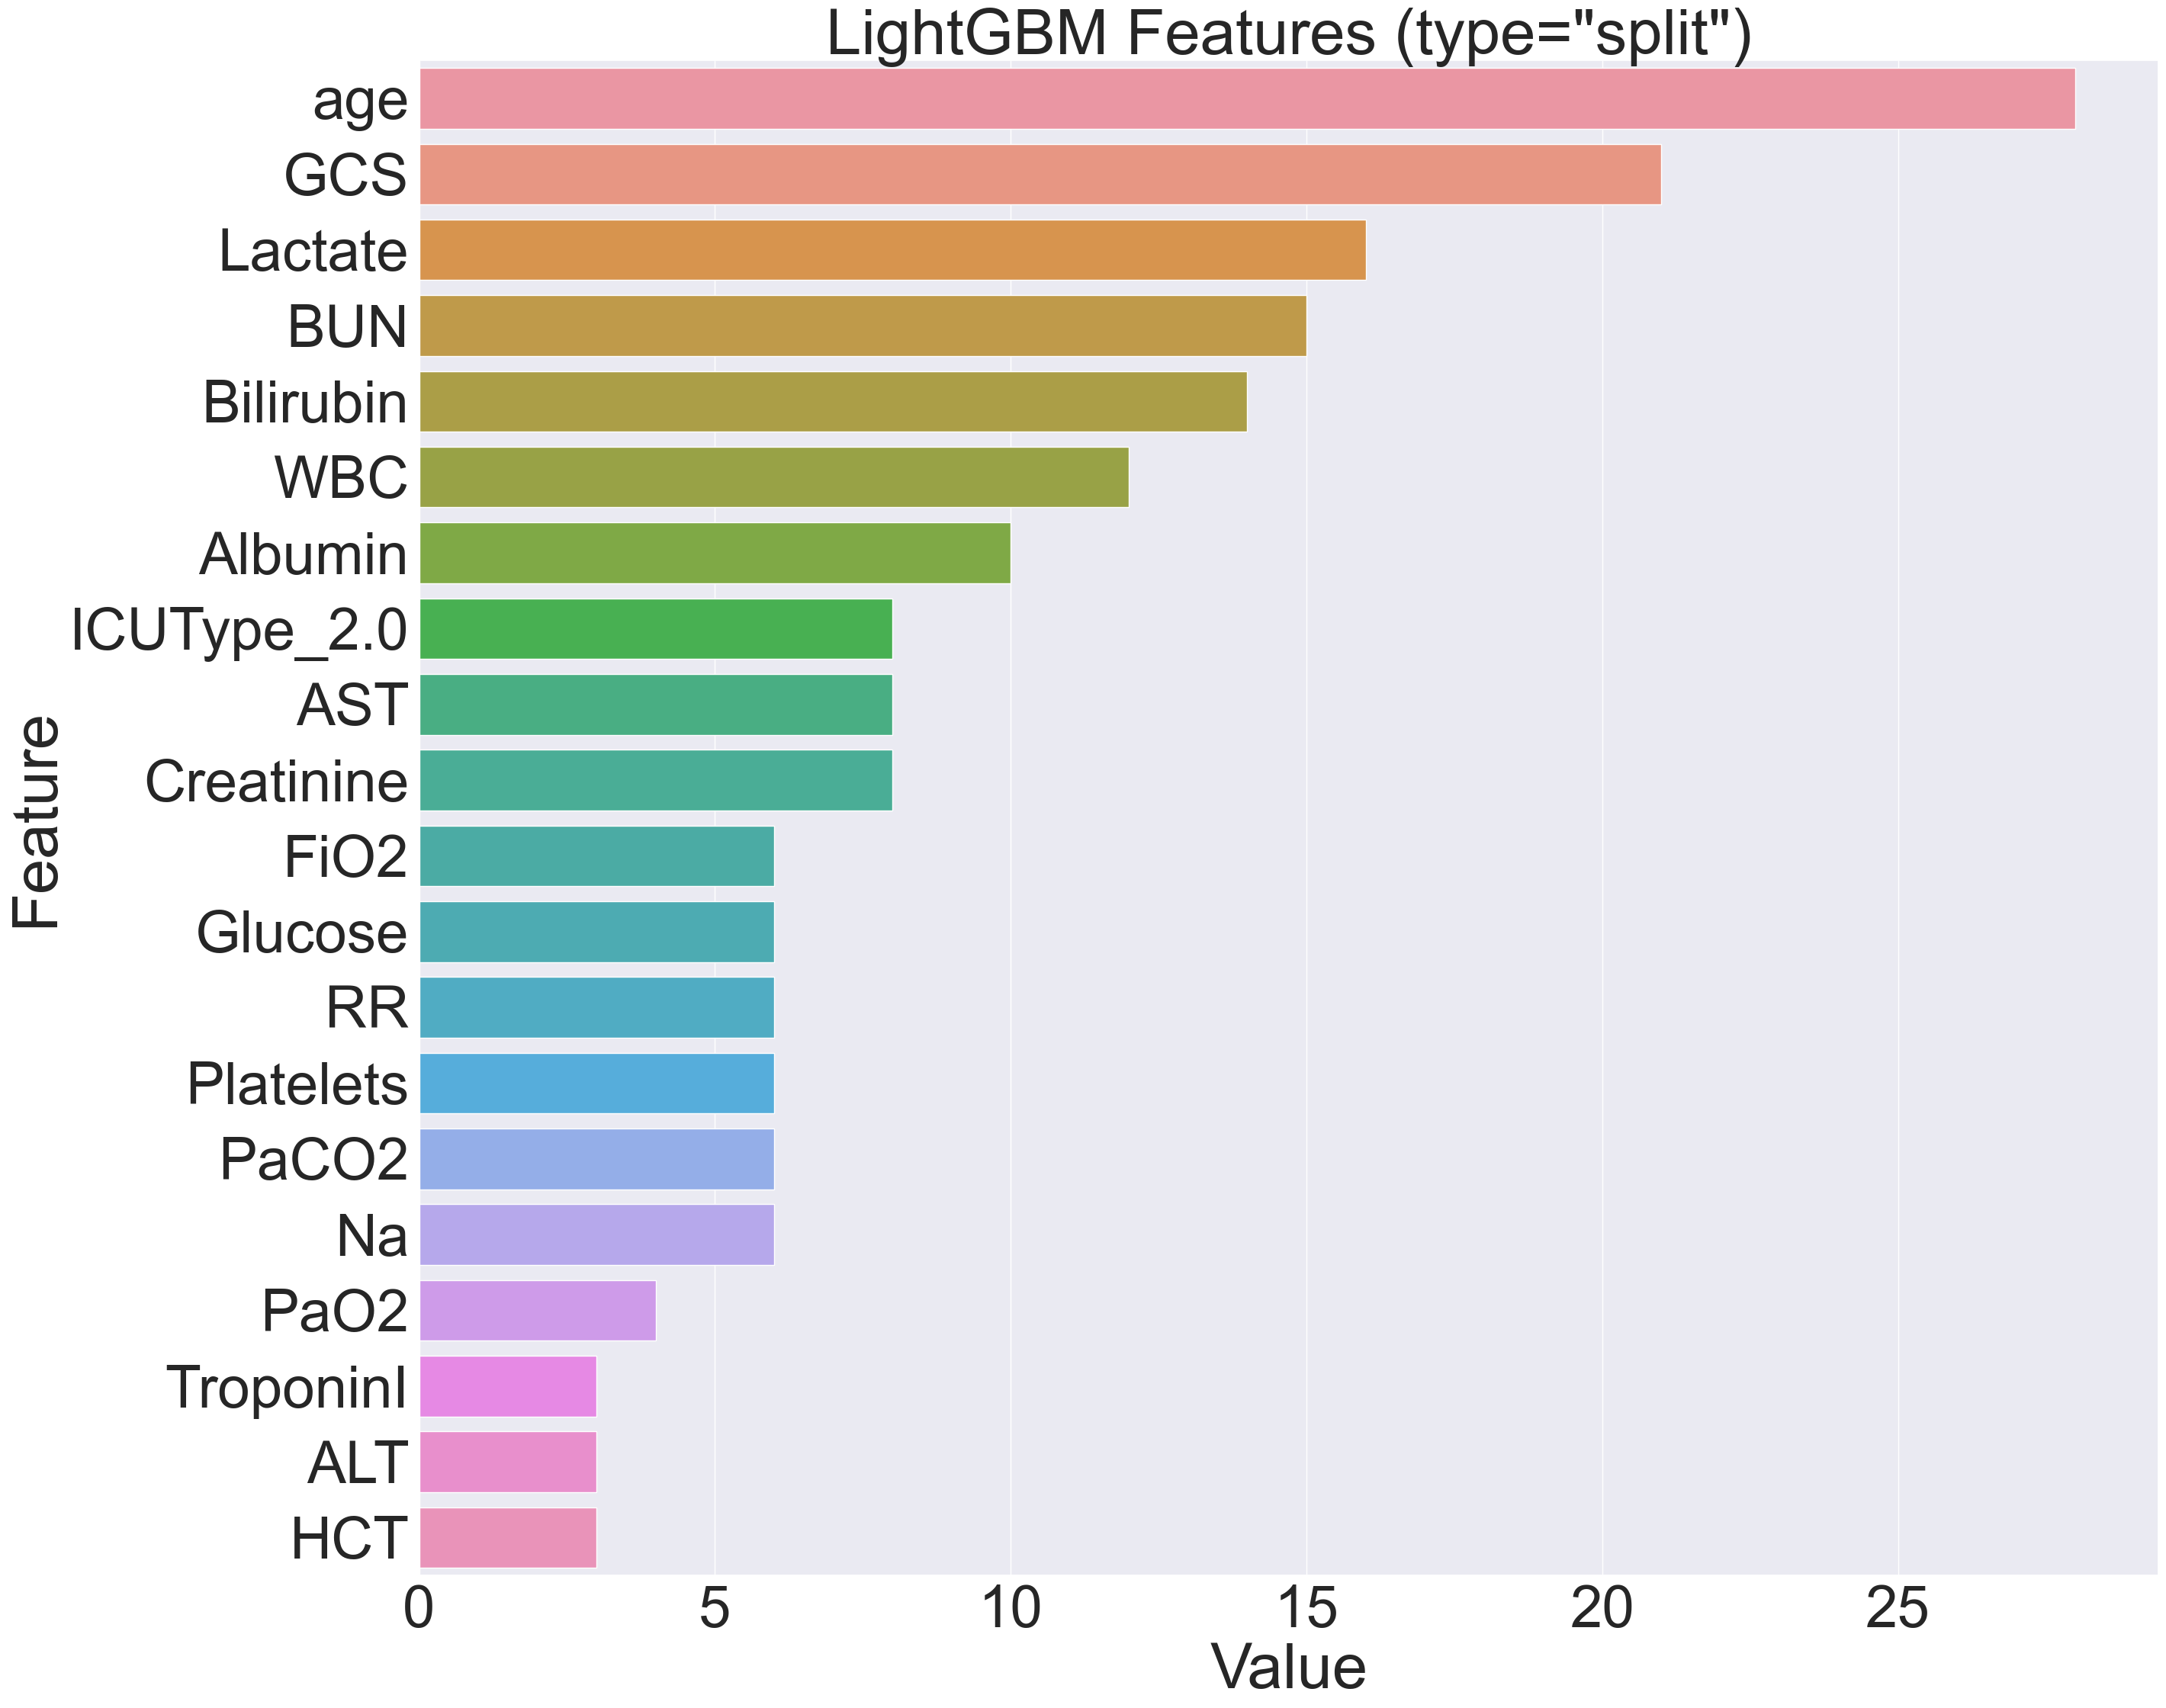

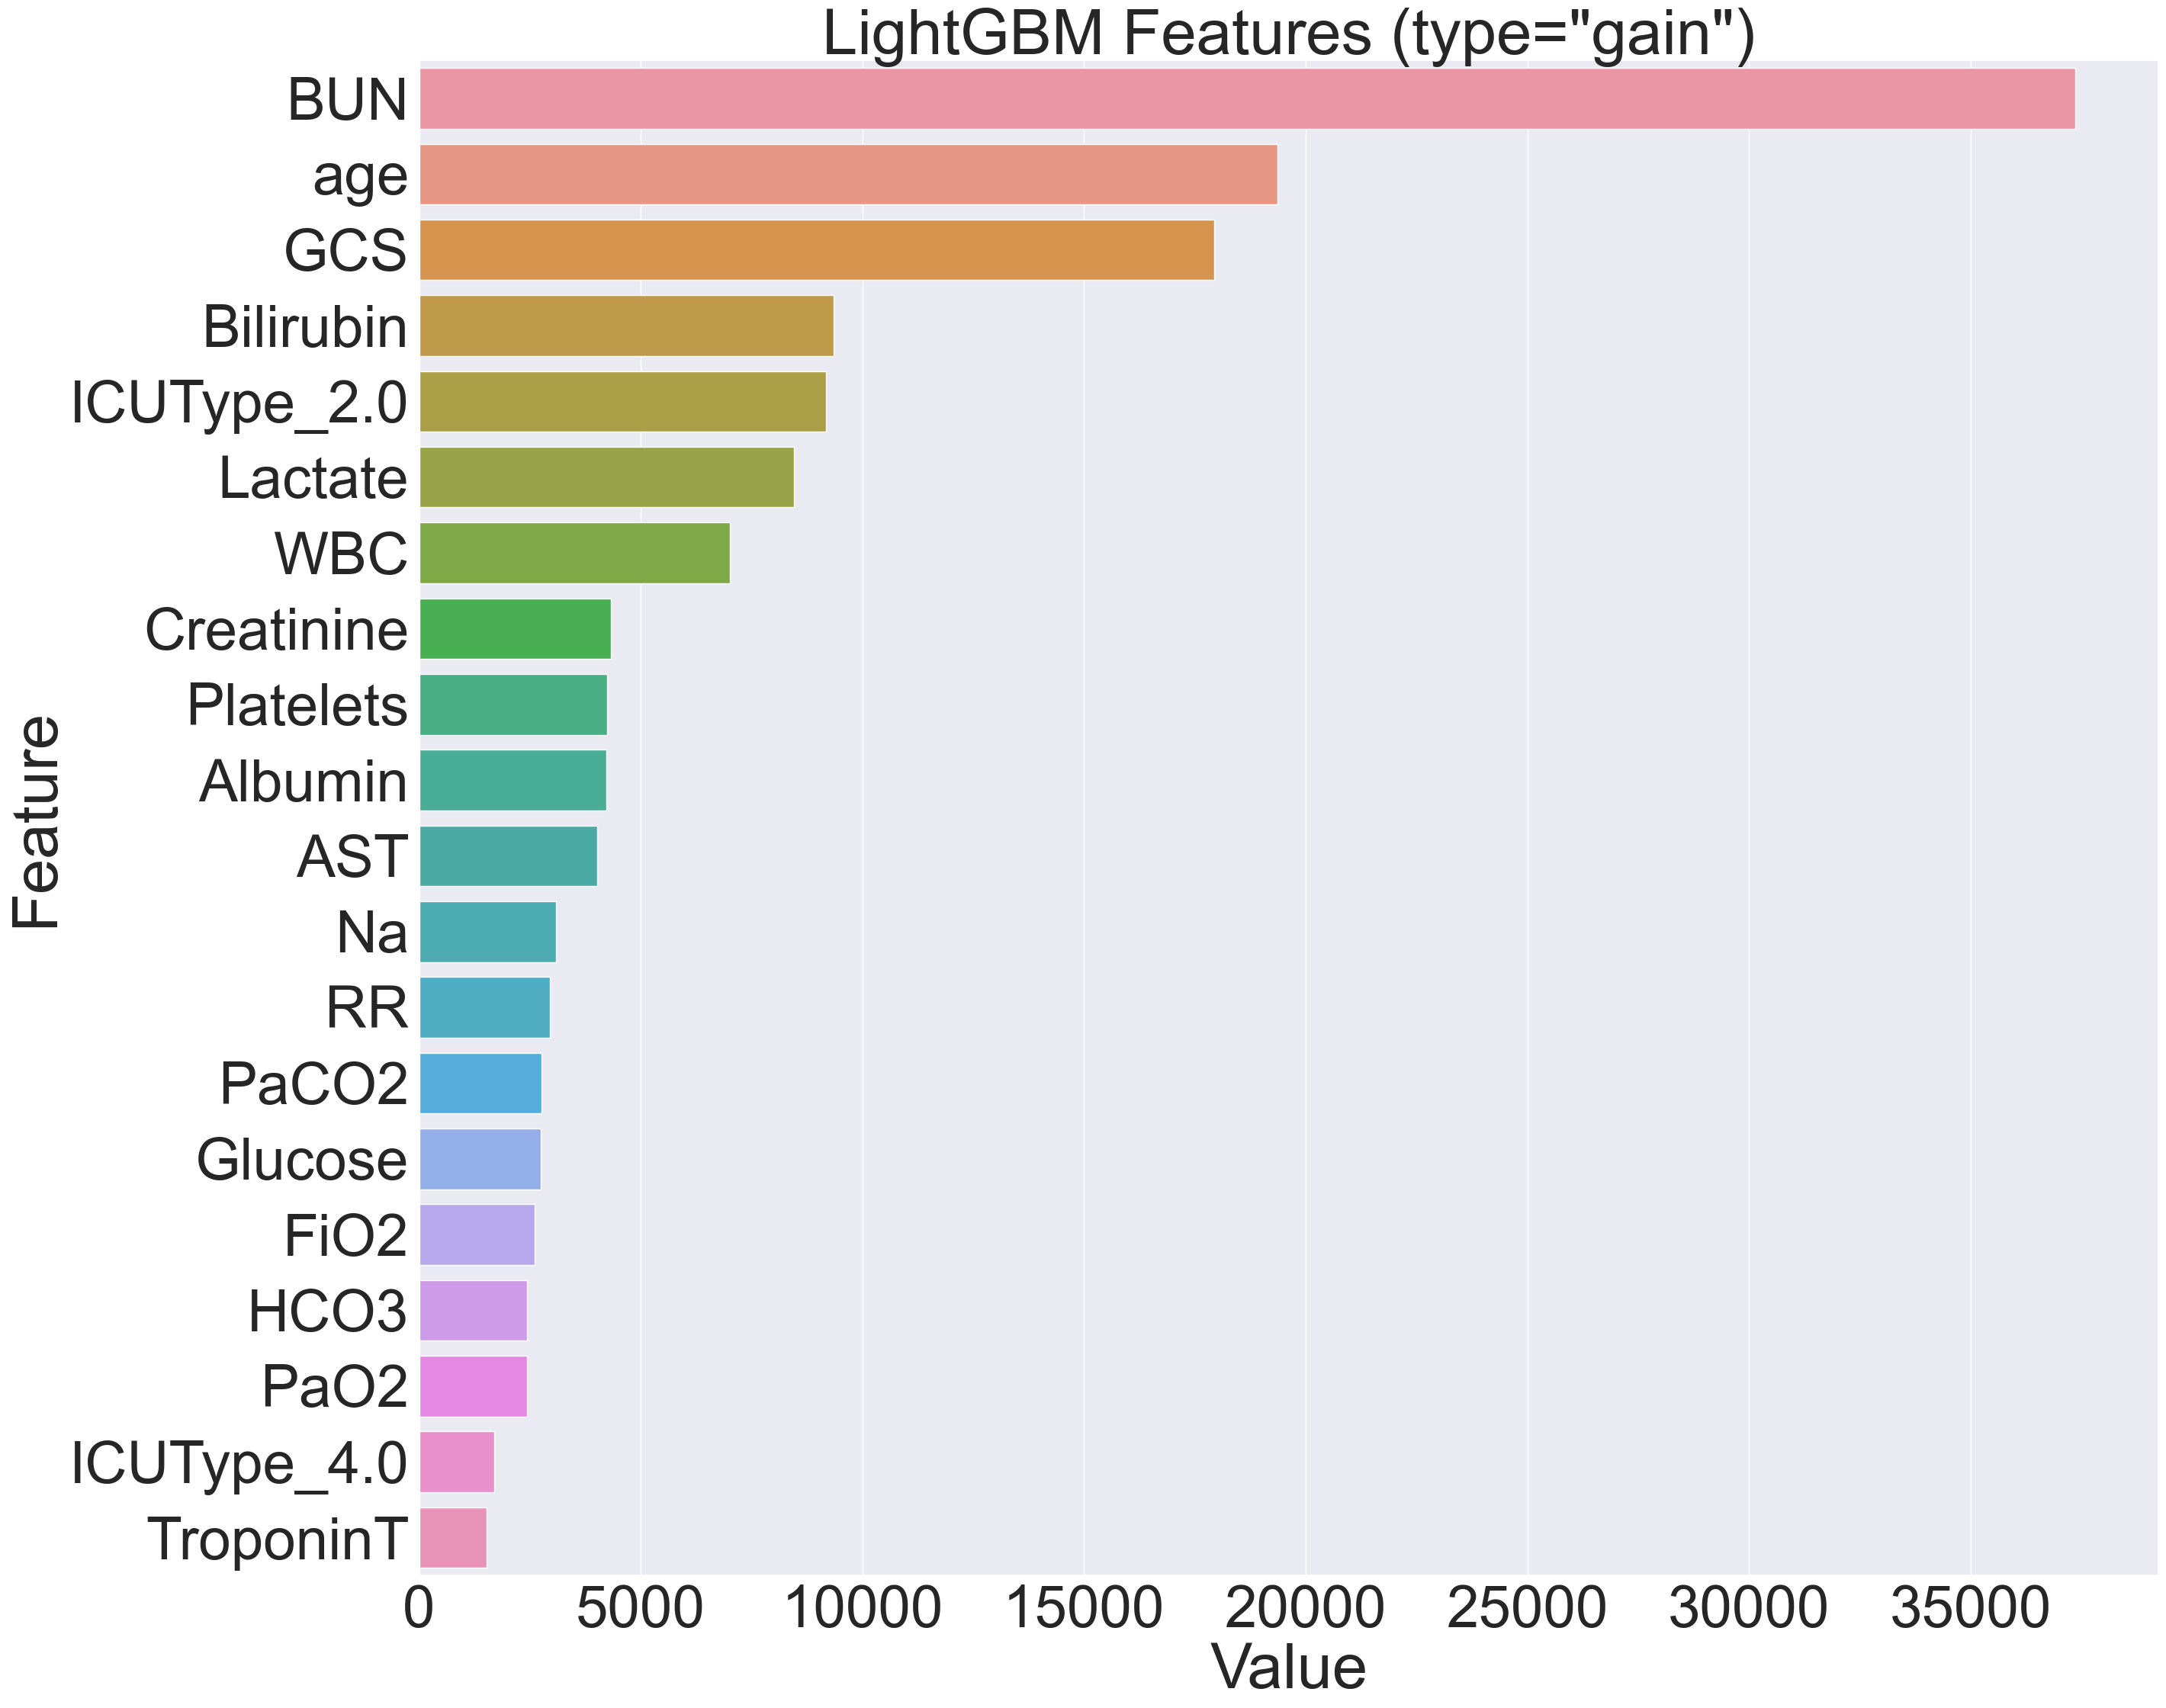

[[28 'age']
 [21 'GCS']
 [16 'Lactate']
 [15 'BUN']
 [14 'Bilirubin']
 [12 'WBC']
 [10 'Albumin']
 [8 'ICUType_2.0']
 [8 'AST']
 [8 'Creatinine']]
[[37364.61019897461 'BUN']
 [19356.989044189453 'age']
 [17934.284088134766 'GCS']
 [9352.536102294922 'Bilirubin']
 [9178.555084228516 'ICUType_2.0']
 [8457.495971679688 'Lactate']
 [7019.001037597656 'WBC']
 [4321.959991455078 'Creatinine']
 [4244.592956542969 'Platelets']
 [4222.165023803711 'Albumin']]
length of X_test_nonorm.columns:  40
length of bst.feature_importance:  40


In [14]:
# lgb.train 메소드 사용하기 - early_stopping, model_save, best_iteration 제공.
import matplotlib.pyplot as plt
import seaborn as sns

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_valid, label=y_valid)

param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = ['auc', 'binary_logloss']

num_round = 400
bst = lgb.train(param, train_data, num_round, valid_sets=[val_data],
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

pred = bst.predict(X_test, num_iteration=bst.best_iteration)
bst.save_model(path+'lgb_model_best_upto_machine.txt', num_iteration=bst.best_iteration)
# loaded_model = lgb.Booster(model_file=path+'lgb_model_best_upto_machine.txt')
print('roc_auc_score of test: ', roc_auc_score(y_test, pred))

num=20
fig_size=(30,24)

# importance_type='split'
feat_import_split = dict(ll for ll in zip(np.array(X_test_nonorm.columns), bst.feature_importance(importance_type='split')))
feature_imp_split = pd.DataFrame({'Value':feat_import_split.values(),'Feature':feat_import_split.keys()})
plt.figure(figsize=fig_size)
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp_split.sort_values(by="Value", 
                                                    ascending=False)[0:num])
plt.title('LightGBM Features (type="split")')
plt.tight_layout()
plt.savefig(path+'lgbm_importances_spit.png')
plt.show()

# importance_type='gain'
feat_import_gain = dict(ll for ll in zip(np.array(X_test_nonorm.columns), bst.feature_importance(importance_type='gain')))
feature_imp_gain = pd.DataFrame({'Value':feat_import_gain.values(),'Feature':feat_import_gain.keys()})
plt.figure(figsize=fig_size)
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp_gain.sort_values(by="Value", 
                                                    ascending=False)[0:num])
plt.title('LightGBM Features (type="gain")')
plt.tight_layout()
plt.savefig(path+'lgbm_importances_gain.png')
plt.show()

print(feature_imp_split.sort_values(by='Value', ascending=False)[0:10].to_numpy())
print(feature_imp_gain.sort_values(by='Value', ascending=False)[0:10].to_numpy())

print('length of X_test_nonorm.columns: ', len(X_test_nonorm.columns))
print('length of bst.feature_importance: ', len(bst.feature_importance()))

### 특성공학을 위한 features 선정
- lgbm.feature_importance()이용
- 결국 gai, spl을 모두 합쳐서 11개의 features를 뽑고, 그 중에서 'ICUType_2.0', 'age'는 static이라 제거
- 총 9개의 features를 가지고 특성공학을 진행하기로 함.
- {‘Platelets’, AST’, ‘Albumin’, ‘BUN’, ‘WBC’, ‘Creatinine’, ‘Bilirubin’, ‘GCS’, ‘Lactate’}

In [24]:
spl = set(feature_imp_split.sort_values(by='Value', ascending=False)[0:10].to_numpy()[:, 1])
gai = set(feature_imp_gain.sort_values(by='Value', ascending=False)[0:10].to_numpy()[:,1])
print(gai-spl)
print(spl-gai)
print(spl)

{'Platelets'}
{'AST'}
{'AST', 'ICUType_2.0', 'Albumin', 'BUN', 'WBC', 'age', 'Creatinine', 'Bilirubin', 'GCS', 'Lactate'}


In [10]:
# import matplotlib.pyplot as plt

# lgb.plot_importance(lgb_clf)

In [11]:
# # Permutation Importance

# from eli5.lightgbm import *
# from eli5.sklearn import *
# import eli5

# perm = PermutationImportance(bst, random_state=42).fit(X_test, y_test)
# print(eli5.format_as_text(explain_weights.explain_permutation_importance(perm, feature_names = X_test_nonorm.columns, top=num)))

# explain_weights.explain_permutation_importance(perm, feature_names = X_test_nonorm.columns, top=num)


In [12]:
# # colab gpu 설정

# !git clone --recursive https://github.com/Microsoft/LightGBM
# %cd /content/LightGBM
# !mkdir build
# !cmake -DUSE_GPU=1
# !make -j$(nproc)
# !sudo apt-get -y install python-pip
# !pip install --upgrade pip
# !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
# %cd /content/LightGBM/python-package/
# !sudo python setup.py install --precompile

In [13]:
# from sklearn.model_selection import GridSearchCV
# import time
# import lightgbm as lgb
# import pickle

# start = time.time()

# lgbm = lgb.LGBMClassifier(n_estimators = 400) #Define the parameters
# parameters = {'num_leaves':[31, 100, 200, 300], 'max_depth':[15,20,25], 'objective':['binary'],
#              'learning_rate':[0.001,0.005,0.01],'min_data_in_leaf':[20, 100, 300, 500]}#Define the scoring
# clf=GridSearchCV(lgbm, parameters, scoring='roc_auc', 
#                  cv=3, verbose=True)
# clf.fit(X, y) # train data와 valid data를 합침.
# print(clf.best_params_)
# predicted=clf.best_estimator_.predict(X_test)
# print('Classification of the result is:')
# print(roc_auc_score(y_test, predicted))
# end = time.time()
# print('Execution time is:')
# print(end - start)

